<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [38]:
# Load cancer dataset
from sklearn import datasets
dataset = datasets.load_breast_cancer()
X = dataset.data
Y = dataset.target
target_names = dataset.target_names

In [39]:
#80/20 split for train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=10)

In [40]:
#evaluate with malignant (0) as the positive class
def eval_three(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    return acc, prec, rec

In [41]:
#Base pipeline (scaler to SVC)
base_pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])

In [42]:
# Use different kernels and varying C
C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
kernel_cfgs = {
    "linear":  {"fixed": {"svc__kernel": "linear"},  "vary": {"svc__C": C}},
    "rbf":     {"fixed": {"svc__kernel": "rbf", "svc__gamma": "scale"}, "vary": {"svc__C": C}},
    "poly":    {"fixed": {"svc__kernel": "poly", "svc__degree": 3, "svc__gamma": "scale"}, "vary": {"svc__C": C}},
    "sigmoid": {"fixed": {"svc__kernel": "sigmoid", "svc__gamma": "scale"}, "vary": {"svc__C": C}},
}

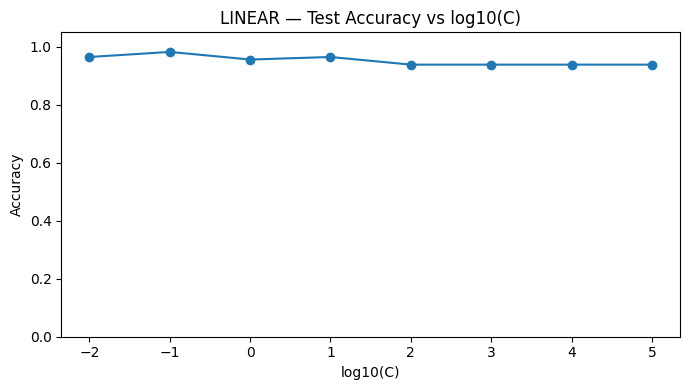

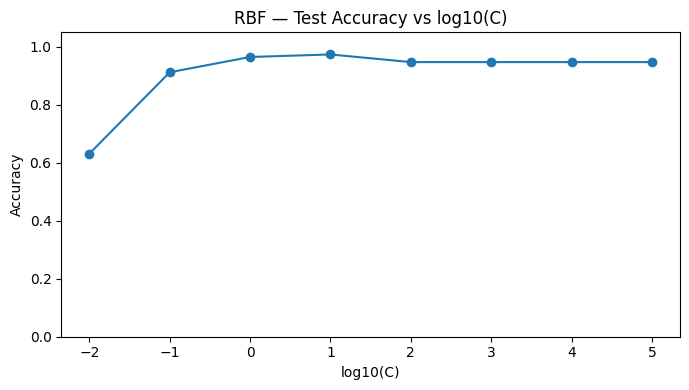

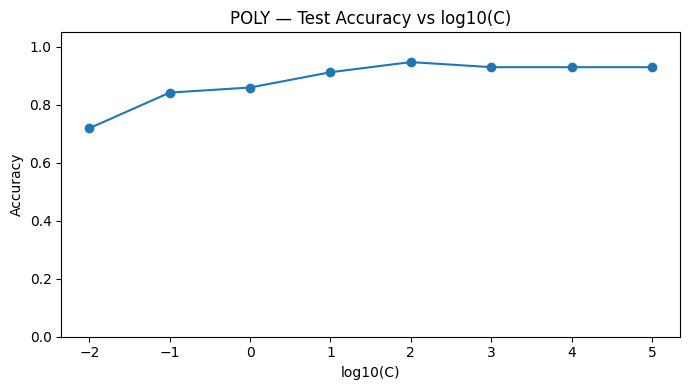

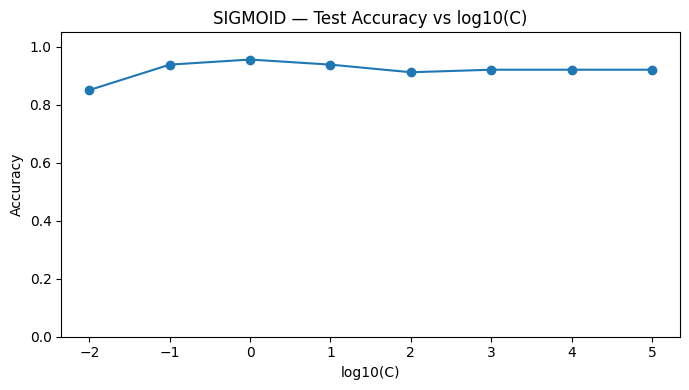

In [43]:
all_results = []
best_per_kernel = {}

for kernel, cfg in kernel_cfgs.items():
    accs, precs, recs = [], [], []
    Cs = cfg["vary"]["svc__C"]

    for C in Cs:
        model = base_pipe.set_params(**cfg["fixed"], svc__C=C)
        model.fit(X_train, Y_train)
        yhat = model.predict(X_test)
        acc, prec, rec = eval_three(Y_test, yhat)
        accs.append(acc); precs.append(prec); recs.append(rec)

        all_results.append({
            "Kernel": kernel, "C": C,
            "Accuracy": acc, "Precision(malig)": prec, "Recall(malig)": rec
        })

    # Sensitivity plot: Accuracy vs log10(C)
    plt.figure(figsize=(7,4))
    plt.plot(np.log10(Cs), accs, marker='o')
    plt.title(f"{kernel.upper()} — Test Accuracy vs log10(C)")
    plt.xlabel("log10(C)"); plt.ylabel("Accuracy"); plt.ylim(0, 1.05)
    plt.grid(False); plt.tight_layout(); plt.show()

    # Store best-by-accuracy C for this kernel
    best_idx = int(np.argmax(accs))
    best_per_kernel[kernel] = {
        "C": Cs[best_idx],
        "Accuracy": accs[best_idx],
        "Precision(malig)": precs[best_idx],
        "Recall(malig)": recs[best_idx],
    }





In [44]:
#summary table : best C per kernel
summary_rows = []
order = ["rbf", "linear", "poly", "sigmoid"]
for k in order:
    bp = best_per_kernel[k]
    summary_rows.append({
        "Model": f"SVM-{k}",
        "Best C": bp["C"],
        "Accuracy": bp["Accuracy"],
        "Precision (malignant)": bp["Precision(malig)"],
        "Recall (malignant)": bp["Recall(malig)"]
    })
summary_df = pd.DataFrame(summary_rows)
print("\n=== Best per kernel (NO PCA, 80/20 split; metrics on test set) ===")
print(summary_df.round(4).to_string(index=False))



=== Best per kernel (NO PCA, 80/20 split; metrics on test set) ===
      Model  Best C  Accuracy  Precision (malignant)  Recall (malignant)
    SVM-rbf    10.0    0.9737                 0.9535              0.9762
 SVM-linear     0.1    0.9825                 0.9762              0.9762
   SVM-poly   100.0    0.9474                 0.9500              0.9048
SVM-sigmoid     1.0    0.9561                 0.9512              0.9286


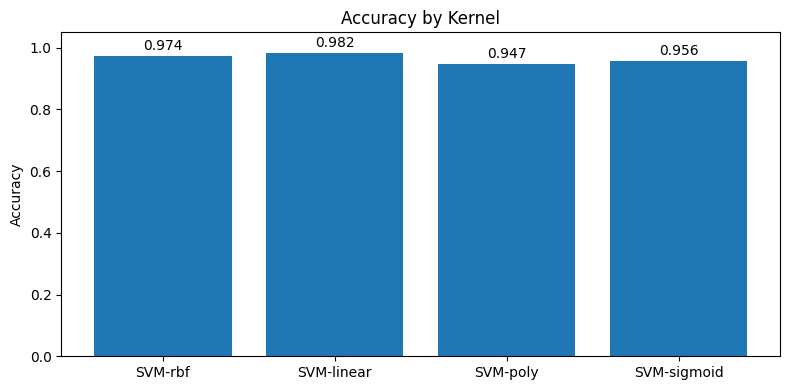

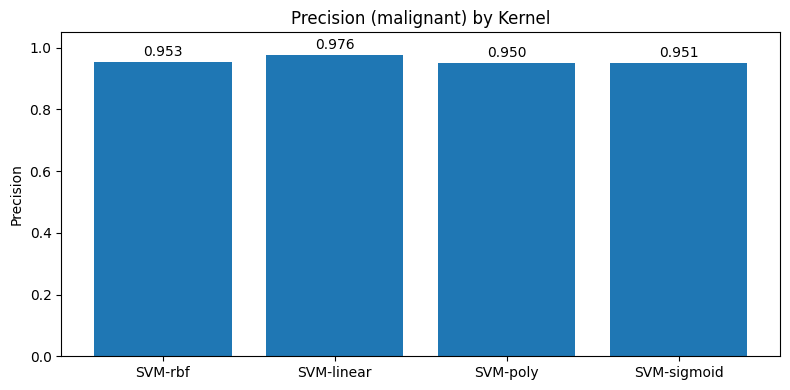

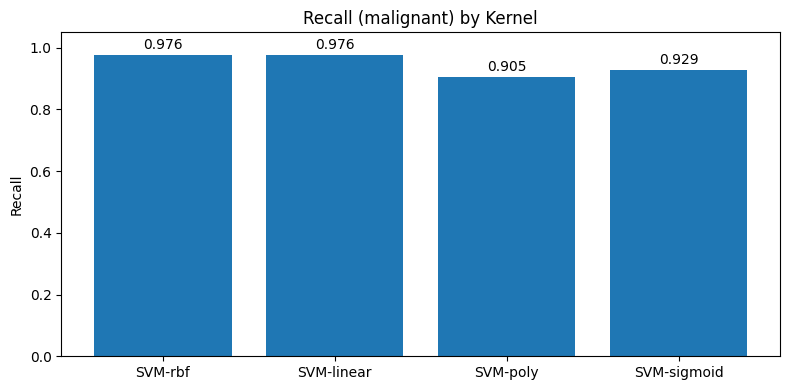

In [45]:
#bar charts to compare results
def bar_plot(labels, values, title, ylabel):
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.bar(labels, values)  # define 'bars'
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    for b, v in zip(bars, values):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + 0.01,
            f"{v:.3f}",
            ha="center", va="bottom"
        )

    fig.tight_layout()
    plt.show()

labels = [f"SVM-{k}" for k in order]
acc_vals  = [best_per_kernel[k]["Accuracy"]         for k in order]
prec_vals = [best_per_kernel[k]["Precision(malig)"] for k in order]
rec_vals  = [best_per_kernel[k]["Recall(malig)"]    for k in order]

bar_plot(labels, acc_vals,  "Accuracy by Kernel", "Accuracy")
bar_plot(labels, prec_vals, "Precision (malignant) by Kernel", "Precision")
bar_plot(labels, rec_vals,  "Recall (malignant) by Kernel", "Recall")

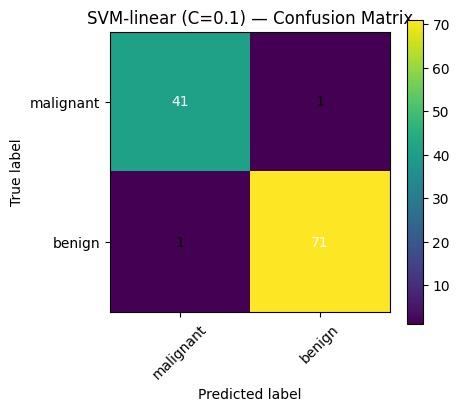

In [46]:
# Confusion matrix for the single best SVM among kernels
best_kernel_name = labels[int(np.argmax(acc_vals))]
best_kernel_key = order[int(np.argmax(acc_vals))]
best_C = best_per_kernel[best_kernel_key]["C"]
best_model = base_pipe.set_params(**kernel_cfgs[best_kernel_key]["fixed"], svc__C=best_C).fit(X_train, Y_train)
cm = confusion_matrix(Y_test, best_model.predict(X_test), labels=[0,1])

plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title(f"{best_kernel_name} (C={best_C}) — Confusion Matrix")
plt.colorbar()
tick = np.arange(2)
plt.xticks(tick, target_names, rotation=45)
plt.yticks(tick, target_names)
th = cm.max()/2
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

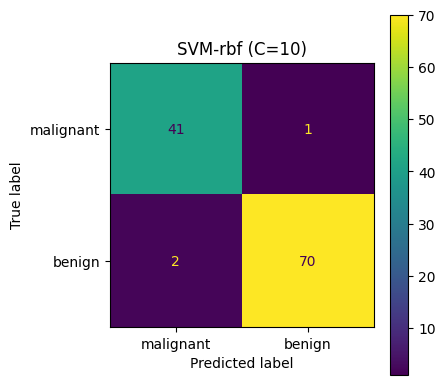

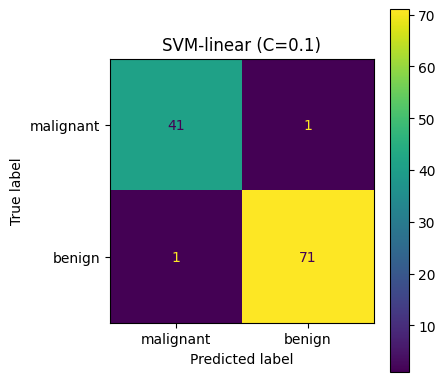

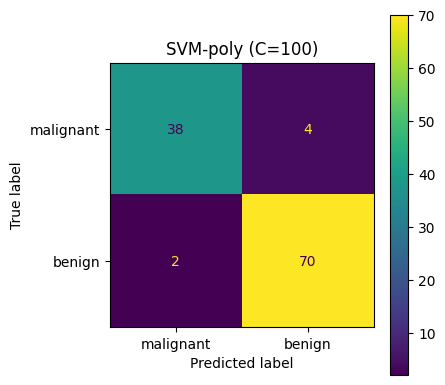

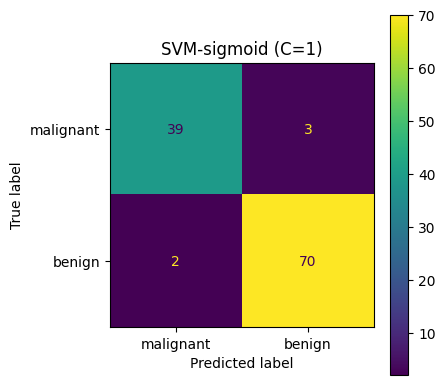

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for all kernels at their best C
for kernel in ["rbf", "linear", "poly", "sigmoid"]:
    C_best = best_per_kernel[kernel]["C"]
    cfg = kernel_cfgs[kernel]["fixed"]  # fixed settings for this kernel (gamma/degree, etc.)

    # Refit on full training with best C
    model = base_pipe.set_params(**cfg, svc__C=C_best).fit(X_train, Y_train)
    yhat = model.predict(X_test)

    # Confusion matrix (labels: 0=malignant, 1=benign)
    cm = confusion_matrix(Y_test, yhat, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["malignant", "benign"])

    fig, ax = plt.subplots(figsize=(4.6, 4.2))
    disp.plot(ax=ax, values_format='d', colorbar=True)
    ax.set_title(f"SVM-{kernel} (C={C_best})")
    plt.tight_layout()
    plt.show()